In [142]:
# import libraries
from asyncio import sleep
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
from pathlib import Path
import ipyvolume as ipv
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if p%(l//4)==0: # only print 4 times per run
        print(p, '/', l)

### 2D Flow Z velocity Slice Image Experiment

This experiment measures a sliced 2D Y/Z image of the Z component of the flow velocity.

Flow speed can be controlled with the Stepper Control dashboard app.
The final image may be incorrect due to phase wrapping if the flow speed is too fast.

First we set a directory and experiment name for saving the data:

In [323]:
# set save directory and base file name
SAVE_DIR = '/home/data/flow-slice'
SAVE_NAME = 'bar_downward_1000_flow_YZ_64scans'

# make the save directory if it doesn't exist
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

#### Now we run the experiment:
1. load the pulse sequence
2. load global variables (pulse calibration, frequency, shims)
3. set up 2D slice imaging parameters
4. set negative flow encode gradient and run the sequence, storing k-space data as `y_vzn`
5. set positive flow encode gradient and run the sequence, storing k-space data as `y_vzp`

Notes:
- The maximum velocity before phase wrapping,`VENC`, can be adjusted by changing `t_flow` and `t_flow_spacing`. `t_flow_spacing` must be at least 100e-6 seconds longer than `t_flow` for the timing to work. `t_echo` may also need to be increased for the timings to work if `t_flow` and `t_flow_spacing` are increased.
- If there is an apparent gradient of velocity across the sample with no flow, this is due to mismatch between the positive and negative gradient pulses of the flow encode module, and can be fixed with the `t_flow_tweak` parameter which fine tunes the length of the second flow encode gradient pulse. A value of a few microseconds (`~1e-6`) should be sufficient.

In [324]:
# load pulse sequence
seq = Sequence('flow-slice-SE.py')

# load relevant global variables
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')

# seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'softpulse_90_4.0mm.yaml')
# slice through X axis using magnitude from softpulse calibration file
g_slice = seq.par.g_slice*np.array([1.0, 0, 0])

DECIMATION = 4

G_CAL = 8.0e6 # Hz/m at max grad
G_FLOW = np.array((0, 0, 0.8))

# set parameters for a 32x64 Y/Z 2D slice SE image
seq.setpar(
    g_slice=g_slice,
    
    # phase encode Y axis
    n_phase_1=32,
    g_phase_1=(0, -0.8, 0),
    
    # frequency encode Z axis
    g_phase_read=(0, 0, 0.8),
    t_dw=5e-6,
    n_samples=DECIMATION*64,
    g_read=(0, 0, -0.3), # controls FOV
    
    g_spoil=(0, 0, 1.0), # same direction as read gradient
    t_spoil=1000e-6,
    
    t_flow=600e-6, # duration of flow encode gradient
    t_flow_spacing=700e-6, # spacing between flow encode gradients (measured between centres)
    g_flow=(0,0,0),
    t_flow_tweak=2.3e-6, # calibrate by measuring with no flow, and adjust until the measured flow velocity is zero everywhere
    
    t_echo=4e-3,
    t_end=50e-3,
    n_scans=64
)

# auto calculate t_phase
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_read))*(seq.par.t_dw*seq.par.n_samples)/2)

# calculate VENC, the velocity that produces a pi phase shift
VENC = np.pi/(2*np.pi*G_CAL*2*np.linalg.norm(G_FLOW)*seq.par.t_flow*seq.par.t_flow_spacing)

# print out the parameter set for reference
print(seq.par)
print(f'Venc: {VENC:.3f} m/s')

# not perfectly accurate, but close enough
# (t_echo measures to the centre of the acquisition, so there is still some extra delay before t_spoil)
time_est_s = 2*(seq.par.n_scans*seq.par.n_phase_1*seq.par.n_phase_2*(seq.par.t_end+seq.par.t_echo+seq.par.t_spoil))
print('total time (mins):', time_est_s/60)

print('Acquiring image with negative flow encoding')
seq.setpar(g_flow=-G_FLOW)
await seq.run(progress_handler=print_progress)
y_vzn = decimate(np.reshape(seq.data, (seq.par.n_phase_1, seq.par.n_samples)), DECIMATION, axis=1)
# save data and parameters
np.save(f'{SAVE_DIR}/{SAVE_NAME}_vzn', y_vzn)
seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}_vzn.yaml')

print('Acquiring image with positive flow encoding')
seq.setpar(g_flow=G_FLOW)
await seq.run(progress_handler=print_progress)
y_vzp = decimate(np.reshape(seq.data, (seq.par.n_phase_1, seq.par.n_samples)), DECIMATION, axis=1)
np.save(f'{SAVE_DIR}/{SAVE_NAME}_vzp', y_vzp)
seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}_vzp.yaml')

ParameterSet(n_scans=64, f=15049030.981428321, a_90=0.20108232301911808, t_90=0.00025, bw_90=20000.0, a_180=0.7320384050983709, t_180=3.2e-05, t_dw=5e-06, n_samples=256, t_echo=0.004, g_slice=array([0.6, 0. , 0. ]), g_read=array([ 0. ,  0. , -0.3]), t_phase=0.00023999999999999998, g_phase_read=array([0. , 0. , 0.8]), n_phase_1=32, g_phase_1=array([ 0. , -0.8,  0. ]), n_phase_2=1, g_phase_2=array([0., 0., 0.]), t_flow=0.0006, t_flow_spacing=0.0007, t_flow_tweak=2.3e-06, g_flow=array([0., 0., 0.]), t_spoil=0.001, g_spoil=array([0., 0., 1.]), t_grad_stab=0.0001, t_end=0.05, t_grad_ramp=0.0001, n_grad_ramp=10, shim_x=-0.16202908646463288, shim_y=-0.02758646006984458, shim_z=0.3261526264305465, shim_z2=0.017020833292368354, shim_zx=0.11191848554353294, shim_zy=0.10382238875034588, shim_xy=0.08158038633566658, shim_x2y2=0.044061359453251264)
Venc: 0.093 m/s
total time (mins): 3.754666666666667
Acquiring image with negative flow encoding
8 / 32
16 / 32
24 / 32
32 / 32
Acquiring image with pos

In [333]:
# LOAD_DIR = '/home/data/flow-slice'
# LOAD_NAME = 'bar_downward_1000_flow_YZ_64scans'
# y_vzn = np.load(f'{LOAD_DIR}/{LOAD_NAME}_vzn.npy')
# y_vzp = np.load(f'{LOAD_DIR}/{LOAD_NAME}_vzp.npy')
# seq.loadpar(f'{LOAD_DIR}/{LOAD_NAME}_vzp.yaml')

#### Reconstruct the images from k-space data using fourier method:

In [334]:
# run FFT with some upscaling and windowing to get the images
im_vzn = fft_reconstruction(y_vzn, upscale_factor=2, gaussian_blur=1)
im_vzp = fft_reconstruction(y_vzp, upscale_factor=2, gaussian_blur=1)

#### Plot the images and a mask of regions with significant signal:

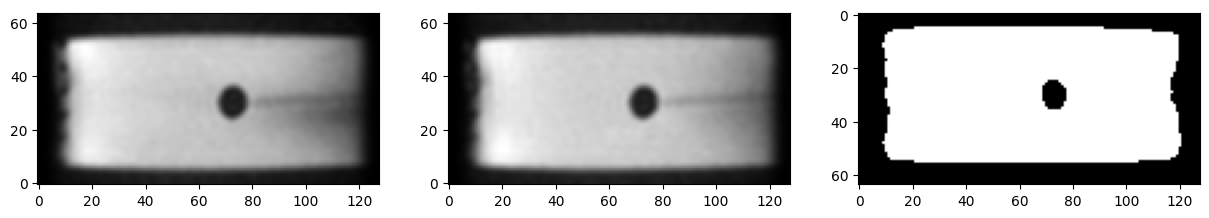

In [335]:
# make a filter array by thresholding the magnitude of the signal
# this can be used to exclude areas with no signal when plotting phase difference
filt = np.abs(im_vzn)*np.abs(im_vzp)
thresh = 0.1*np.max(filt) # adjust to alter the threshold, quarter of maximum is a good starting point
filt[filt > thresh] = 1
filt[filt <= thresh] = 0

# plot the signal magnitudes of the two images and the resulting filter
cmap = 'gray'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].imshow(np.abs(im_vzn), cmap=cmap, origin='lower')
axes[1].imshow(np.abs(im_vzp), cmap=cmap, origin='lower')
axes[2].imshow(filt, cmap=cmap)
plt.show()

#### Plot the phase of the images
The flow encode gradients will introduce a phase shift proportional to the flow velocity in the direction of the gradient.
We can plot maps of the phase to see this phase shift directly.

Note: the phase may also vary across the image, but we are interested in the difference between the two images.

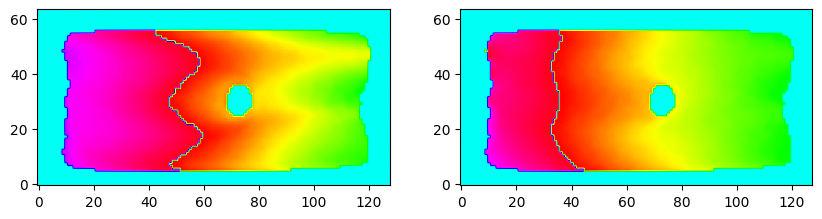

In [336]:
# plot the phase of the images
cmap='hsv' # cyclical colormap for phase plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(filt*np.angle(im_vzn), vmin=-np.pi, vmax=np.pi, cmap=cmap, origin='lower')
axes[1].imshow(filt*np.angle(im_vzp), vmin=-np.pi, vmax=np.pi, cmap=cmap, origin='lower')
plt.show()

#### Calculate the flow velocity map

In [337]:
# calculate velocity from phase difference (uncalibrated, arbitrary units)
vz = -(VENC/np.pi)*filt*np.angle(im_vzp/im_vzn) # dividing complex numbers will take the difference of their angles

# maximum velocity magnitude, used for plots
vz_mag_max = np.nanmax(np.sqrt(vz*vz))
print('maximum speed:', vz_mag_max, 'm/s')

maximum speed: 0.03986025219946861 m/s


#### Plot flow velocity as a color coded image
Note: discontinuities in the flow velocity indicate that the flow speed is too fast, or flow encode gradient too strong, causing phase wrapping.

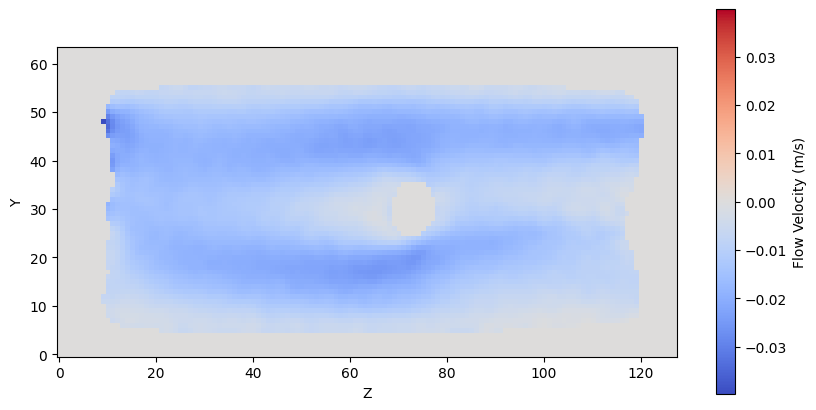

In [338]:
# plot signed velocity profile
plt.figure(figsize=(10,5))
plt.imshow(vz, cmap='coolwarm', vmin=-vz_mag_max, vmax=vz_mag_max, origin='lower')
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(label='Flow Velocity (m/s)')
plt.show()

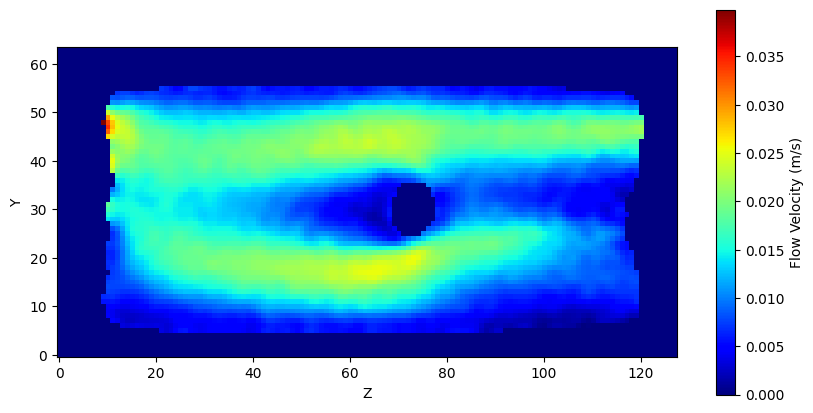

In [339]:
# plot velocity magnitude profile
plt.figure(figsize=(10,5))
plt.imshow(np.abs(vz), cmap='jet', origin='lower')
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(label='Flow Velocity (m/s)')
plt.show()